## Spending analysis

This is a notebook I use to analyse my personal spending.  
It loads in CSV files downloaded from my bank into a dataframe.  
  
I have obscured the names of the categories, and multiplied all amounts by a random number to protect personal information.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import re
%matplotlib inline
from random import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Gets rid of the seaborn 'FutureWarning'

In [2]:
def get_data():

    df = pd.DataFrame()

    #Read files from folder, tidy up columns, and append to dataframe
    destdir = Path(r'data')
    files = [i for i in destdir.iterdir() if i.is_file()]
    for i in files:
        df_i = pd.read_csv(i)
        df_i.columns = ['Date', 'Shop', 'Amount Spent','Amount In','e']
        df_i.drop(['e'], axis=1, inplace = True) 
        df_i.fillna(0, inplace=True)
        df = df.append(df_i, sort=False, ignore_index=True)

    # Tidy up final dataframe
    df.set_index('Date', inplace=True)
    df.reset_index(inplace=True)
    df['Date']=df['Date'].apply(pd.to_datetime)
    df = df.sort_values('Date')
    print(f'Loaded {len(df)} transactions from {str(df.Date.min()).split()[0]} to {str(df.Date.max()).split()[0]}')
    return df

In [3]:
df = get_data()

#Create some new columns
df['year'] = df['Date'].apply(lambda date: date.year)
df['month']= df['Date'].apply(lambda date: date.month)
df['day']= df['Date'].apply(lambda date: date.day)
df['YearMonth']= df['month'].apply(str)+'-'+df['year'].apply(str)
df['Day of Week']  = df['Date'].apply(lambda date: ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun'][date.weekday()])

Loaded 705 transactions from 2018-05-16 to 2019-01-23


To obscure my private data I multiply all the transaction amounts by a random number between 0 and 1.  
  
I've also dropped the shop name in the following output

In [4]:
random_multiplier = random()
df['Amount Spent'] = df['Amount Spent']*random_multiplier
df.drop('Shop', axis=1).tail()

,Date,Amount Spent,Amount In,year,month,day,YearMonth,Day of Week
234,2019-01-20,10.624991,0.0,2019,1,20,1-2019,Sun
235,2019-01-20,24.637907,0.0,2019,1,20,1-2019,Sun
236,2019-01-21,9.019285,0.0,2019,1,21,1-2019,Mon
237,2019-01-22,9.110389,0.0,2019,1,22,1-2019,Tue
238,2019-01-23,12.862730,0.0,2019,1,23,1-2019,Wed


In [5]:
#Split into spending and incoming
spending = df[df['Amount Spent']!=0].drop(['Amount In'], axis=1)
incoming = df[df['Amount In']!=0].drop(['Amount Spent'], axis=1)

The following cell contains a dictionary with regular expression matching transactions to categories.

For privacy i've renamed the categories A-J, and retroactively obscured the regexs that were used:

In [6]:
#Categorize spending

categories = {
        'A' : [''],  #This dict populated by regular expression to match
        'B' : [''],
        'C' : [''],
        'D' : [''],
        'E' : [''],
        'F' : [''],
        'G' : [''],
        'H' : [''],
        'I' : [''],
        'J' : ['']
}

def categorize(transaction):
    for c in categories.keys():
        for pattern in categories[c]:
            if re.search(pattern, transaction, re.IGNORECASE):
                return c
    return "Unclassified"


spending['Category'] = spending['Shop'].apply(categorize)

#For classifying new transactions:
#unclassifieds = spending[spending['Category']=='Unclassified'].groupby('Shop').sum()['Amount Spent'].sort_values(ascending=False)
#print(f'Number unclassified = {len(unclassifieds)}. Unclassified value = ${sum(unclassifieds)}. Shops ordered by spending:\n{unclassifieds}')

In [7]:
#Generate report and plots for a given month (or all months) and a given category (or all categories)

# Yearmonth is  '(m)m-yyyy' or 'All'
# For possible categories, set 'category' to 'show'
# Plots is 'bar', 'barh', 'pie', etc., or 'None'

def report(yearmonth='All', category='All', plots='None'):
    if yearmonth[0]=='0':
        yearmonth = yearmonth[1:]
        
    if category == 'show':
        print('Possible categories:')
        cats = list(categories.keys())
        cats.append('All')
        return cats
    
    if category=='All' and yearmonth!='All':
        data = spending[spending['YearMonth']==yearmonth].groupby('Category').sum().sort_values('Amount Spent', ascending=False)['Amount Spent']
        print('Report for {}\n'.format(yearmonth))
        total = data.sum()
        print('Total spent = ${:.2f}\n '.format(total))
        print('Breakdown :')
        print(data)
        if plots != 'None':
            data.plot(kind=plots, title = 'Spending in {}. Total spend = ${:.2f}'.format(yearmonth, total), subplots=True, figsize=(8,8), legend=False)
        
    elif category!='All' and yearmonth=='All':
        data = spending[spending['Category']==category].groupby('Shop').sum().sort_values('Amount Spent', ascending=False)['Amount Spent']
        print('Report for {} spending, all-time\n'.format(category))
        total = data.sum()
        print('Total spent = ${:.2f}\n'.format(total))
        print('Breakdown :')
        print(data)
        if plots != 'None':
            data.plot(kind=plots, title='{} spending, all-time. Total spend = ${:.2f}'.format(category, total), subplots=True, figsize=(8,8), legend=False)
        
    elif category=='All' and yearmonth=='All':
        data = spending.groupby('Category').sum().sort_values('Amount Spent', ascending=False)['Amount Spent']
        print('Report for all spending, all-time:\n')
        total = data.sum()
        print('Total spent = ${:.2f}\n '.format(total))
        print('Breakdown :')
        print(data)
        if plots != 'None':
            data.plot(kind=plots, title='All spending, all-time. Total spend = ${:.2f}'.format(total), subplots=True, figsize=(8,8), legend=False)    
        
    elif category!='All' and yearmonth!='All':     
        data = spending[(spending['YearMonth']==yearmonth) & (spending['Category']==category)].groupby('Shop').sum().sort_values('Amount Spent', ascending=False)['Amount Spent']
        print("Report for {} spending in {}:\n".format(category, yearmonth))
        total = data.sum()
        print('Total spent = ${:.2f}\n '.format(total))
        print('Breakdown :')
        print(data)
        if plots != 'None':
            data.plot(kind=plots, title='{} spending in {}. Total spend = ${:.2f}'.format(category, yearmonth, total), subplots=True, figsize=(8,8), legend=False, label=False)

Report for all spending, all-time:

Total spent = $20116.75
 
Breakdown :
Category
I               5073.797476
F               3184.502170
Unclassified    2732.706612
A               2525.644561
J               1582.571297
H               1276.900678
G               1106.769865
B                834.568536
E                761.879022
C                554.202020
D                483.209317
Name: Amount Spent, dtype: float64


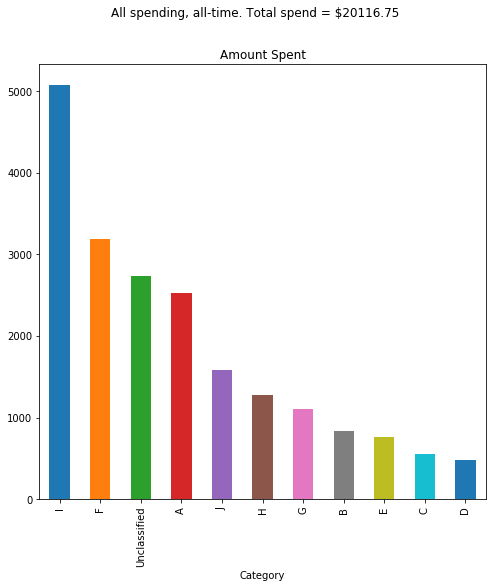

In [8]:
report(yearmonth='All', category = 'All', plots='bar') 

In [9]:
#Function to plot spending for each category over time. Figure is saved
def time_report(save=False):
    def category_over_time(category):
        if category == 'All':
            data = spending
            plt.title('Total spending per month')
        else:
            data = spending[spending['Category']==category]
            plt.title(category)

        spending.groupby(['year', 'month']).sum().sort_values(by=['year', 'month'])['Amount Spent'].plot(kind='bar')
            
    first = spending['Date'].min().strftime('%Y-%m-%d')
    last = spending['Date'].max().strftime('%Y-%m-%d')
    title = f'Monthly spending ({first} to {last})'

    fig = plt.figure(figsize=(25,35), dpi=100) 
    fig.suptitle(title, fontsize=15)  

    for i,cat in enumerate(list(categories.keys())+['Unclassified', 'All']):  #One subplot per category, adding in 'unclassified' category and 'all' plot
        fig.add_subplot(4, 4, i+1, xmargin=0.25, ymargin=0.25)
        category_over_time(cat)
        plt.xlabel("")
    plt.subplots_adjust(top=0.95)
    if save==True:
        fig.savefig(title, bbox_inches = 'tight', pad_inches = 1)

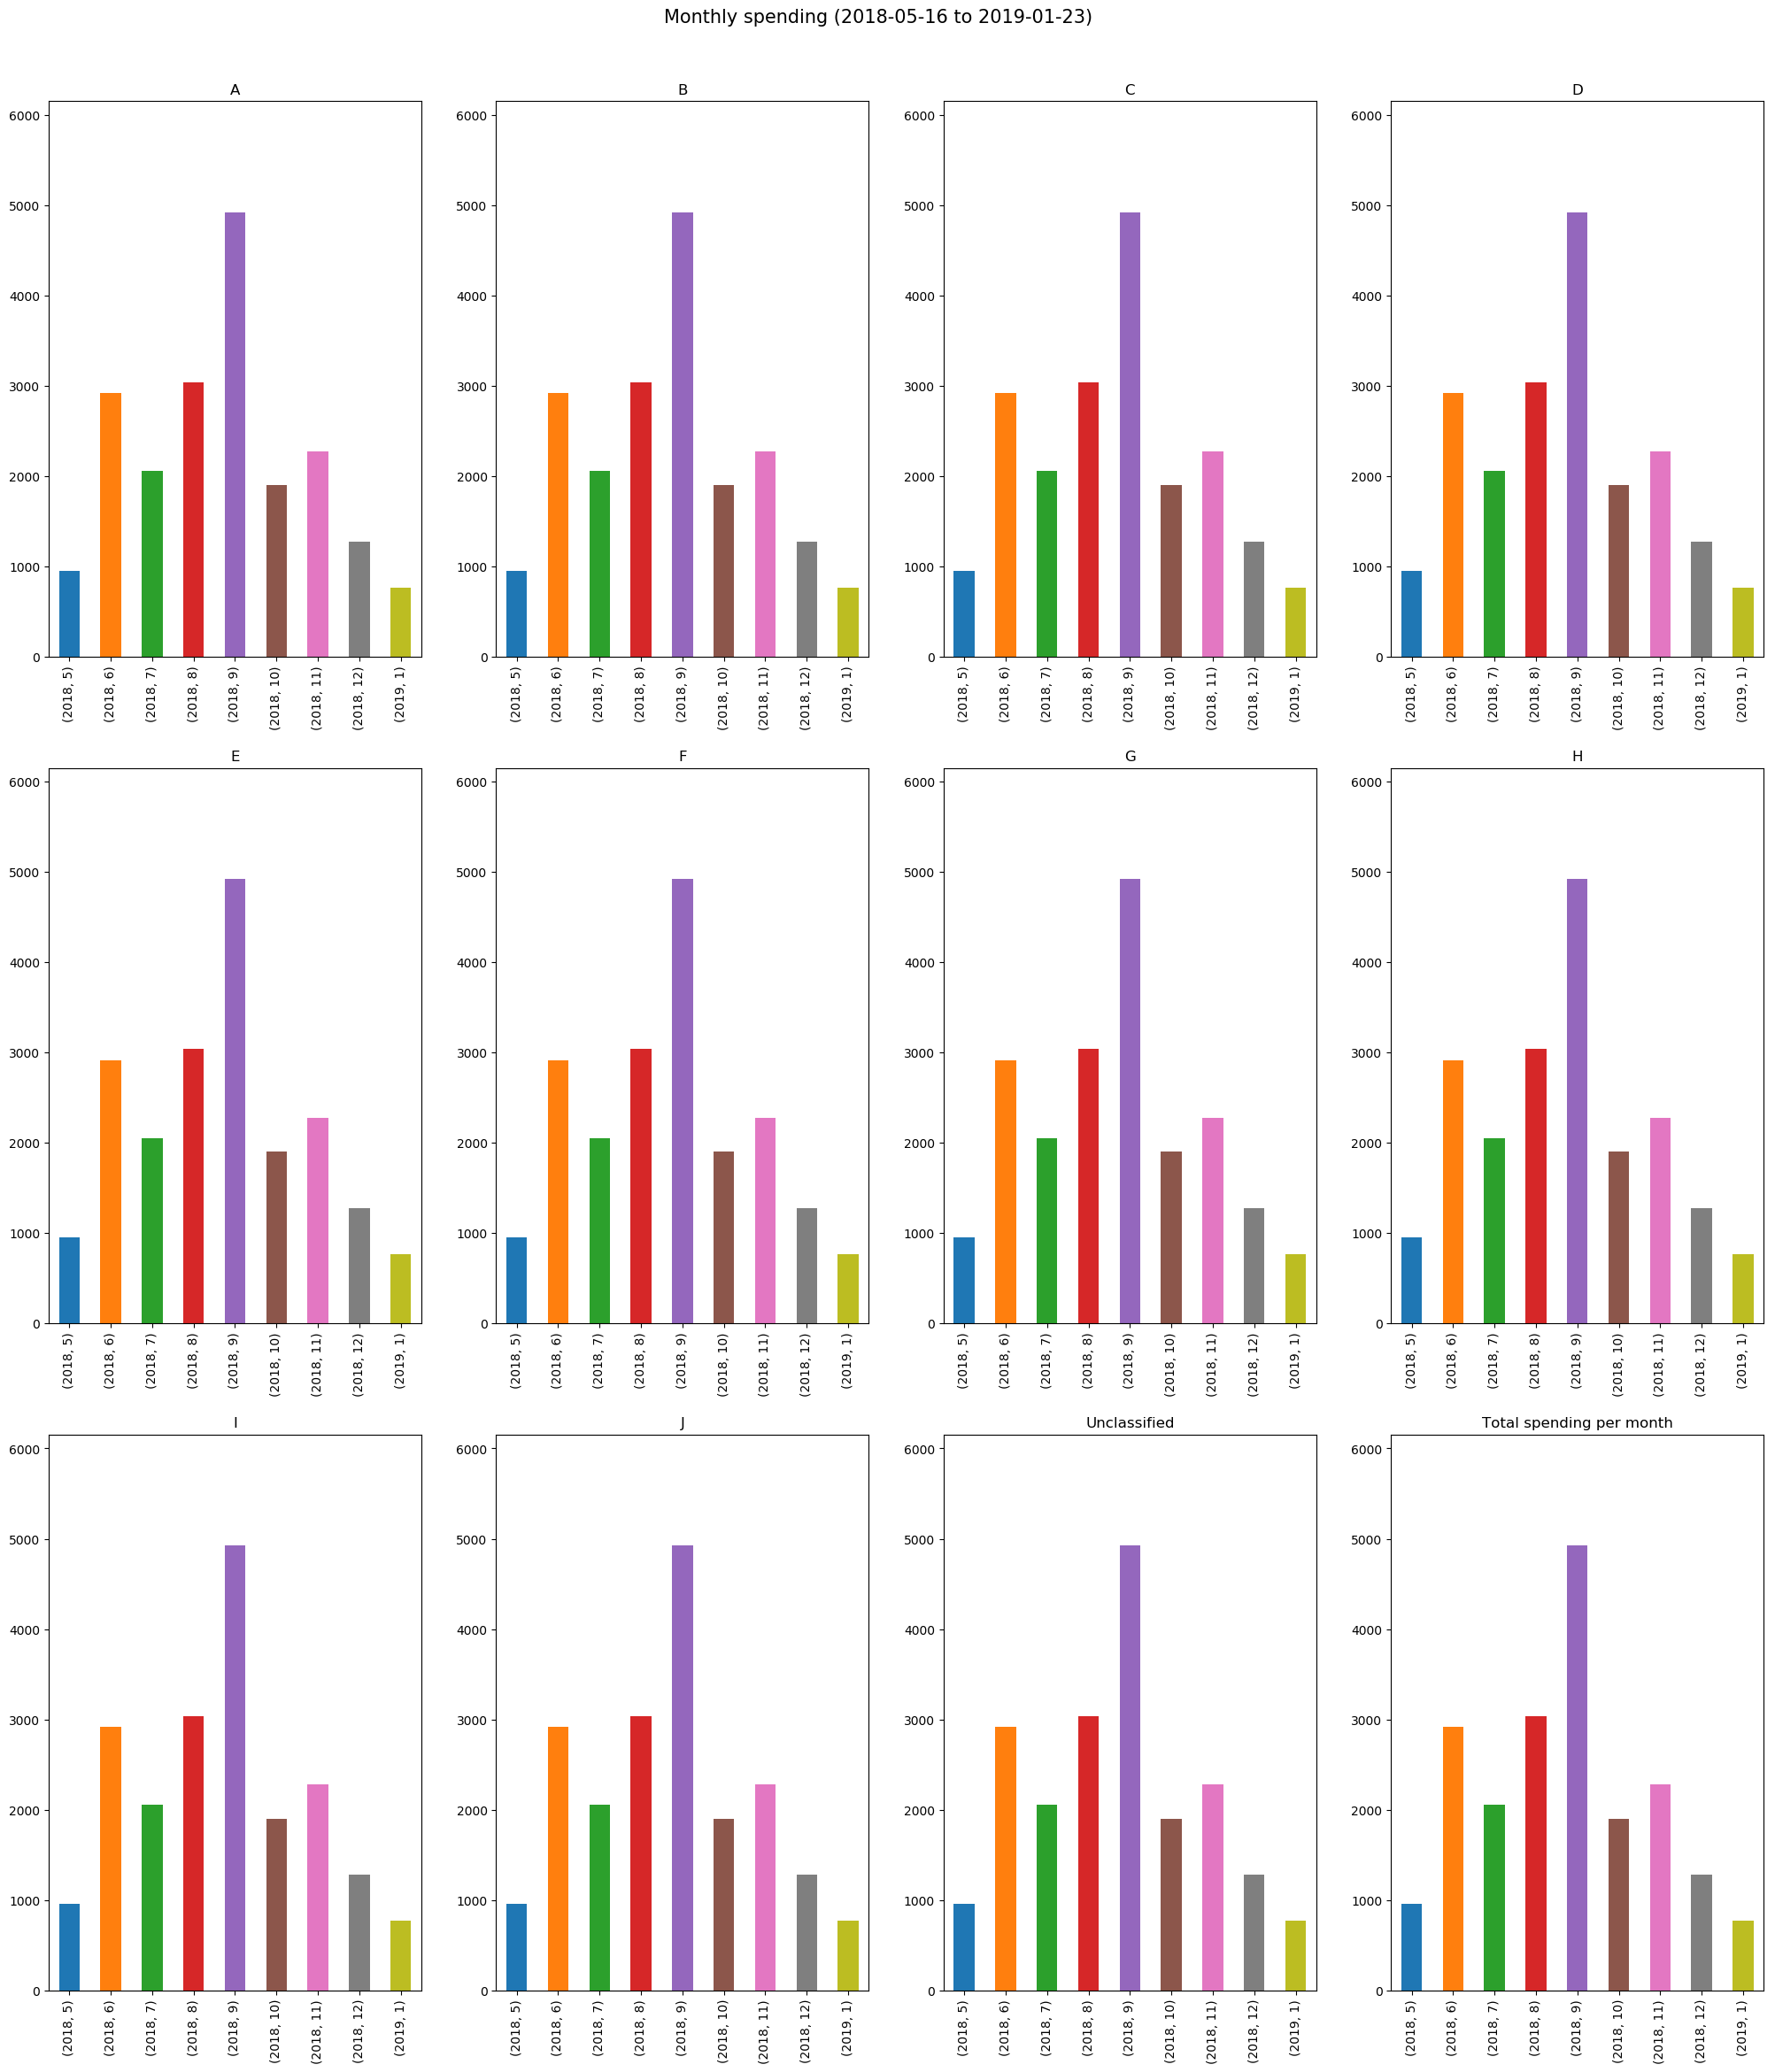

In [10]:
time_report(save=True)